In [1]:
!pip install rdkit kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 66.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 17.2 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.6-py3-none-any.whl size=111943 sha256=02ae70eb8ac461e2c7acf7299b1755b1dfe2b4987eae4ed809792c3b0837036e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/53/34/8c/8ca3450d17206d9e37e1ee3aeb47cbb2873d22a9e0c60eb137
Successfully built kaggle


In [2]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 7.7 MB/s eta 0:00:00


In [3]:
import time
import sys
import pickle
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
import networkx   as nx  # For creating and manipulating graph structures

from   zipfile    import ZipFile
from   datetime   import datetime
from collections import Counter
import random
import re
import psutil
import copy
import json
import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdmolops
from rdkit.Chem import FunctionalGroups

from tqdm       import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim import lr_scheduler
from torch.distributions import Normal

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, mean_absolute_error, r2_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.decomposition   import TruncatedSVD
from sklearn.model_selection import KFold

In [4]:
api_token = {"username":"alji1305","key":"4703b0a6c6a8543e51a6de4131ab05cb"}

with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

with open('kaggle.json', 'r') as file:
    kaggle_credentials = json.load(file)

username = kaggle_credentials['username']
api_key  = kaggle_credentials['key']


os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY']      = api_key

chmod: cannot access ‘/home/ec2-user/.kaggle/kaggle.json’: No such file or directory


In [7]:
# !kaggle datasets download -d basu369victor/zinc250k

In [6]:
with ZipFile('zinc250k.zip') as zp:
    zinc_data = pd.read_csv(zp.open('250k_rndm_zinc_drugs_clean_3.csv'))

adjusted_smiles  = []
for index, smile in enumerate(zinc_data['smiles']):
  smile          = smile.replace('\n', '')
  adjusted_smiles.append(smile)

zinc_data['smiles'] = adjusted_smiles

**Data Details**
1. ssr contains list of lists with indexes that correspond to rings
2. Atoms contains the symbol of the atom corresponding to index
3. Bonds contains tuples of bonded indexes

**More information for JT Algo 24Feb2024**

atom Information:
--
1. Atomic Number: The atomic number uniquely identifies the element of each atom.
2. Formal Charge: The formal charge can affect the molecule's reactivity and properties.
3. Hybridization: The hybridization state of an atom can influence molecular geometry.
4. Explicit and Implicit Hydrogens: Knowing the number of attached hydrogens is crucial for understanding the molecule's structure.
5. Isotope Information: For molecules with isotopes, this information is necessary.
    
Bond Information:
--   
1. Bond Order: You're already capturing single, double, and triple bonds but ensure to include any aromatic bonds explicitly as their electronic structure can influence reactivity.
2. Stereochemistry: For bonds, capturing cis/trans (E/Z) configurations is important for double bonds.

Substructure and Functional Groups:
--
1. Functional Groups: You hinted at identifying alcohols; systematically extend this to other functional groups like carbonyls, amines, etc., as they play significant roles in the molecule's properties and reactivity.
2. Ring Structures: Information about ring size, aromaticity, and saturation can be crucial, especially for heterocyclic compounds.

Stereochemistry:
--
1. Chiral Centers: You're capturing chiral centers, which is excellent. Ensure to include their absolute configuration (R/S) as it can drastically change a molecule's biological activity.
2. Axial and Planar Chirality: For molecules with more complex chiral structures, such as those with axial chirality (e.g., biaryls) or planar chirality.

Molecular Connectivity:
--
1. Graph Representation: Since you're working with a JT-VAE, representing the molecule as a graph (nodes for atoms and edges for bonds) is fundamental. Including connectivity information (which atoms are bonded to which) in a structured format like SMILES or InChI can also be useful for re-constructing the molecule.
2. Physical and Chemical Properties (optional):
While not directly related to the structure, including properties like molecular weight, logP (a measure of hydrophobicity), or even polar surface area could enrich your model's ability to predict not just the structure but also the likeliness of a molecule's existence and its physical behavior.


**Paper Additional Information for Vocabulary 03Mar2024**
1. Each vertex v has a feature vector xv indicating the atom type, valence, and other properties. Similarly, each edge (u,v) ∈ E has a feature vector xuv indicating its bond type, and two hidden vectors νuv and νvu denoting the message from u to v and vice versa.

In [7]:
def metadata_smiles(bonds, mol, smile, atoms_dict):
  # Identify aromatic rings and bond types

  stereo_config_map = {
        Chem.rdchem.BondStereo.STEREOZ: 'cis',
        Chem.rdchem.BondStereo.STEREOE: 'trans',
        Chem.rdchem.BondStereo.STEREONONE: 'none',  # No stereochemistry specified
  }

  atoms             = mol.GetAtoms()
  total_hydrogens   = [atom.GetTotalNumHs() for atom in atoms]
  bonds             = mol.GetBonds()
  aromatic_atoms    = [atom.GetIdx() for atom in atoms if atom.GetIsAromatic()]
  double_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE]
  double_bonds_info = [stereo_config_map[bond.GetStereo()] for bond in bonds 
                       if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE]
  

  triple_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.TRIPLE]
#   fgs               = FunctionalGroups.FindFunctionalGroups(mol)
  double_isomerism  = []
  double_list       = []
  hydrogen_counts   = []
  # Iterate over the neighbors of the atom
        
  for index, bond in enumerate(double_bonds):
    bond_object       = bonds[bond]
    bond_isomerism    = double_bonds_info[index]              
    double_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
    double_list.append(double_bond_atoms)
    double_isomerism.append(bond_isomerism)
    
# Dictionary to map RDKit's stereo configuration enumeration to human-readable strings

  triple_list         = []
  for bond in triple_bonds:
    bond_object       = bonds[bond]
    triple_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
    triple_list.append(triple_bond_atoms)

  # Remove triple and double bonds from list
  # bonds             = [bond for bond in bonds if bond.GetBondType() != Chem.rdchem.BondType.DOUBLE
  #                     and bond.GetBondType() != Chem.rdchem.BondType.TRIPLE]

  tertiary_atoms      = [atom.GetIdx() for atom in atoms if atom.GetDegree() == 3
                       and atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED
                       and not atom.IsInRing()]
  quaternary_atoms    = [atom.GetIdx() for atom in atoms if atom.GetDegree() == 4
                       and atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED
                       and not atom.IsInRing()]
  bonded_atoms        = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in bonds]
  # Identify functional groups (as an example, using alcohols)
  # alcohol_groups = mol.GetSubstructMatches(Chem.MolFromSmarts('CO'))
  valency             = [atom.GetExplicitValence() for atom in atoms]

  # Identify chiral centers
  chiral_centers      = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

  # Assemble the information
  molecule_info     = {
      "atoms":  atoms_dict,
      'bonds':  bonded_atoms,
      "Aromatic_Atoms": aromatic_atoms,
      "Double_Bonds":   double_list,
      "Triple_Bonds":   triple_list,
      "Chiral_Centers": chiral_centers,
      'Tertiary': tertiary_atoms,
      'Quaternary': quaternary_atoms,
      'Bond_Isomerism': double_isomerism,
      'Bonded Hydrogens': total_hydrogens,
      'valence': valency
  }


  return molecule_info


In [8]:
def smiles_to_matrix(zinc_data):

  v1                   = {}
  v2_ring              = {}
  adjacency_matricies  = []
  atom_dict            = {}
  molecule_df          = {}
  max_spanning_trees   = []

  for i, smile in tqdm(enumerate(zinc_data['smiles']), total = len(zinc_data)):
    molecule       = Chem.MolFromSmiles(smile)
    atoms          = [atom.GetSymbol() for atom in molecule.GetAtoms()]

    # Store original atom indexes in dictionary for later to create molecule tokens
    atom_dict      = {index: atom for index, atom in enumerate(atoms)}

    bonds          = [tuple(sorted((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))) for bond in molecule.GetBonds()]

    ssr            = [list(x) for x in Chem.GetSymmSSSR(molecule)]  # GetSymmSSSR finds smallest set of smallest rings
    v2             = set()
    non_ring_bonds = set(sorted(bonds))
    molecule_info  = metadata_smiles(bonds, molecule, smile, atom_dict)
    molecule_df[i] = molecule_info

    # Iterate Through Rings
    for ring in ssr:
      temp_atoms = copy.copy(atoms)

      for index in range(len(ring)):
        begin_atom_idx = ring[index]
        end_atom_idx   = ring[(index + 1) % len(ring)]  # To loop back to the start
        bond           = molecule.GetBondBetweenAtoms(begin_atom_idx, end_atom_idx)

        if bond is not None:
            bond_idx_tuple = tuple(sorted((begin_atom_idx, end_atom_idx)))
            v2.add(bond_idx_tuple)

      # v2
      non_ring_bonds     = set(sorted(non_ring_bonds)) - set(sorted(v2))

      subset_dict        = [atoms, v2, non_ring_bonds]
      v1[i]              = non_ring_bonds

      # Stores all V2 rings after some post processing
      v2_ring[i]         = ssr

    # Step 2: Merge Bridged Rings
    # Example of Bridged Ring: Bicyclo[2.2.2]octane
    if len(ssr) > 0:
      v2_copy     = copy.deepcopy(v2_ring[i])
    # If no rings, all bonds are the bonds calculated initially
    else:
      v1[i]       = bonds
      v2_ring[i]  = None
      v2_copy     = []

    # Could be optimized to not evaluate r1 and r2, as well as r2 and r1 (order doesn't matter) 11 Feb 2024
    counter = 0
    for r1 in v2_copy:
        for r2 in v2_copy:
            # Don't evaluate identical rings and fit algorithm criteria
            if r1 != r2 and len(set(r1).intersection(r2)) > 2:
                # Merge r1 and r2
                counter       += 1
                new_ring       = list(set(r1 + r2))

                # LEFT OFF HERE V2_ring[14004] does not exist look into why 11Feb2024
                v2_ring[i]     =  [ring for ring in v2_ring[i] if ring not in [r1, r2]]


                # Assured our rings are not duplicated
                if new_ring not in v2_ring[i]:
                  v2_ring[i].append(new_ring)


    # Step 3: Find Intersection Atoms (V0)
    # V0 ← atoms being the intersection of three or more clusters in V1 ∪ V2
    # Property that finds tertiary carbons/ any other tertiary molecules (Mostly Carbons)
    all_clusters   = list(v1[i]) + list(v2)
    atoms          = [atom for cluster in all_clusters for atom in cluster]
    atom_counts    = Counter(atoms)
    atom_obj       = molecule.GetAtoms()
    # look for tertiary or quaternary atoms given they are not in rings, since this violates algorithm
    v0             = {atom for atom, count in atom_counts.items() if count >= 3
                      and not atom_obj[atom].IsInRing()}

    # The set of all nodes (V)
    V              = set().union(v1[i])
    if len(ssr) > 0:
      v2_ring[i]   = set([tuple(sub_list) for sub_list in v2_ring[i]])
      V            = V.union([ring for ring in v2_ring[i]])
    V              = V.union(v0)  # Add all atoms from v0


    # Add nodes for each cluster (ring or bond)
    junction_tree = nx.Graph()
    for cluster in V:
        junction_tree.add_node(cluster)

     # Add edges between clusters that share junction atoms
    # Finds the shared atoms for Nodes
    for cluster1 in junction_tree.nodes():
        for cluster2 in junction_tree.nodes():
            if cluster1 != cluster2:

                # Different combinations of Tertiary, single atoms, and ring bonds
                shared_atoms = None
                if isinstance(cluster1, int) and isinstance(cluster2, int):
                  shared_atoms = set([cluster1]).intersection(set([cluster2]))
                elif isinstance(cluster2, int):
                    if cluster2 in cluster1:  # If the single atom is in the cluster
                        shared_atoms = set([cluster2])
                elif isinstance(cluster1, int):
                    if cluster1 in cluster2:  # If the single atom is in the cluster
                        shared_atoms = set([cluster1])
                else:
                  shared_atoms = set(cluster1).intersection(set(cluster2))


                if shared_atoms is not None and len(shared_atoms) > 0:
                  contains_index = any(list(shared_atoms) in tup for tup in list(v1[i]))
                  # Conditions to check for consecutive v1 bonds... (1,2) should be connected to (2, 4)
                  v1_bonds       = True in [list(shared_atoms)[0] in tup for tup in list(v1[i])]

                if shared_atoms:
                    junction_tree.add_edge(cluster1, cluster2, weight=len(shared_atoms))

    if i > 1000:
        break
    # Step 5: Find Maximum Spanning Tree
    mst                    = nx.maximum_spanning_tree(junction_tree)

    # Get the adjacency matrix representing connections
    adj_matrix             = nx.adjacency_matrix(mst)
    adj_matrix             = adj_matrix.todense()

    adjacency_matricies.append(adj_matrix)
    max_spanning_trees.append(mst)

  return adjacency_matricies, molecule_df, max_spanning_trees

adjacency_matricies, molecule_df, junction_tree = smiles_to_matrix(zinc_data)



# adjacency_matricies = pickle.load(open('adjacency_matricies.pckl', 'rb'))
# molecule_df         = pickle.load(open('molecule_df.pckl', 'rb'))
# junction_tree       = pickle.load(open('junction_tree.pckl', 'rb'))

# print('files_loaded')

  0%|          | 1001/249455 [00:04<18:23, 225.10it/s]


In [11]:
# mol = Chem.MolFromSmiles(zinc_data['smiles'][10])
# [list(x) for x in Chem.GetSymmSSSR(mol)]

In [12]:
molecule_df[10]

{'atoms': {0: 'C',
  1: 'C',
  2: 'O',
  3: 'C',
  4: 'C',
  5: 'C',
  6: 'C',
  7: 'O',
  8: 'C',
  9: 'C',
  10: 'C',
  11: 'C',
  12: 'C',
  13: 'C',
  14: 'N',
  15: 'C',
  16: 'N',
  17: 'N',
  18: 'C',
  19: 'C',
  20: 'C',
  21: 'C',
  22: 'C',
  23: 'C',
  24: 'C',
  25: 'F',
  26: 'F',
  27: 'F',
  28: 'C',
  29: 'C',
  30: 'C',
  31: 'O',
  32: 'C',
  33: 'C',
  34: 'C',
  35: 'C'},
 'bonds': [(0, 1),
  (1, 2),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9),
  (6, 10),
  (10, 11),
  (11, 12),
  (12, 13),
  (13, 14),
  (12, 15),
  (15, 16),
  (15, 17),
  (17, 18),
  (18, 19),
  (19, 20),
  (20, 21),
  (21, 22),
  (22, 23),
  (23, 24),
  (24, 25),
  (24, 26),
  (24, 27),
  (17, 28),
  (28, 29),
  (29, 30),
  (30, 31),
  (30, 32),
  (32, 33),
  (33, 34),
  (10, 35),
  (35, 3),
  (29, 11),
  (23, 18),
  (34, 28)],
 'Aromatic_Atoms': [3, 4, 5, 6, 10, 18, 19, 20, 21, 22, 23, 35],
 'Double_Bonds': [(12, 15), (28, 29), (30, 31)],
 'Triple_Bonds': [(13, 14)],
 'C

molecule_df[10]

**Next Step 25Feb2024**
1. Add the total Hydrogen informaiton to single atoms in the graph strucutre

In [9]:
def pad_matricies(adjacency_matricies):

  shapes = []
  for adj_matrix in adjacency_matricies:
    shape = adj_matrix.shape
    shapes.append(shape)

  padding_value = max(shapes)[0] # pull dimension


  padded_matricies = []
  for adj_matrix in tqdm(adjacency_matricies, total = len(adjacency_matricies)):
    # Determine current shape
    current_shape = adj_matrix.shape

    # Calculate padding needed
    padding       = ((0, max(0, padding_value - current_shape[0])),  # Padding for rows
                     (0, max(0, padding_value - current_shape[1])))  # Padding for columns

    # Apply padding
    padded_matrix = np.pad(adj_matrix, padding, mode='constant', constant_values=0)
    padded_matricies.append(padded_matrix)


  return np.array(padded_matricies)





padded_matricies = pad_matricies(adjacency_matricies)


100%|██████████| 1001/1001 [00:00<00:00, 23297.03it/s]


**Uniquely Identifying Substructures**
1. Rings are their own "words"
2. Aromaticity, atoms in ring, # of atoms are needed to identify
3. Chirality is likely important
4. Current Nodes in MST Represent candidates for vocabulary
5. Double and triple bonds can be found by the index in bonds sub dictionary and then calliung atoms dictionary

In [44]:
def construct_vocabulary(adjacency_matricies, molecule_df, junction_tree):
  '''
  Construct Vocabulary for the adjacency matrix, molecule_df, and junction tree
  ------------------------------------------------------------------
  ------------------------------------------------------------------
  Parameters:
    adjacency_matricies: N x N Matrix representing nodes in graph representation
    molecule_df: metadata of molecules including
    junction_tree:

  Returns:
    vocabulary:

  '''
  
  smiles_keys         = list(molecule_df[0].keys())[1:]
  node_valencies      = {}
  molecule_dictionary = {}
  vocabulary          = {}
  valency_dict        = {}
 

  # Could clean up all the code by writing a function that takes a category such as "aromatic_atoms"
  for index in range(len(junction_tree)):
    vocabulary[index]    = {}
    nodes                = junction_tree[index].nodes
    
    molecule_data        = molecule_df[index]
    converted            = None
    molecule             = Chem.MolFromSmiles(zinc_data['smiles'][index])
    bonds                = molecule.GetBonds()
    valency              = molecule_data['valence']
    valency_dict[index]  = []
    iterated_nodes       = []
#     valency_dict[index]  = [valency[sub_node] for node in nodes for sub_node in (node if isinstance(node, tuple) else [node])]
    
    # Initialize Structure Counts
    aromatic_count       = 1
    ring_count           = 1
    bond_count           = 1
    dbl_bond_count       = 1
    trp_bond_count       = 1
    tertiary_count       = 1
    quaternary_count     = 1
    molecule_index       = 1
     
    for node in nodes:
      ring_structures    = []
      for descriptor in smiles_keys:
        # Need to fix this to find elements beter 05 Feb 2024
        # Tuple can either be a pair of bonds (single, double, or triple) or ring
        valencies           = [valency[sub_node] for sub_node in 
                              (node if isinstance(node, tuple) else [node])]
        
        # Book Keeping Data To Query Later
        if node not in iterated_nodes:
            iterated_nodes.append(node)
            valency_dict[index].append(valencies)

        if isinstance(node, tuple):
          conversions    = []
          node_len       = len(node)
          atoms          = molecule_data[descriptor]
#           print(node)
          # Normal Rings and Aromatic Rings are separated
          # Need to get the non aromatic rings now, unique identifying them
          if node_len > 2 and descriptor == 'Aromatic_Atoms':
              
              shared_atoms = (set(atoms).intersection(set(node)))
              if shared_atoms == set(node):
                vocabulary[index][descriptor + ' ' + str(aromatic_count)] = []
                for ind_atom in node:
                    converted  = molecule_data['atoms'][ind_atom]
                    conversions.append((ind_atom, converted))

                vocabulary[index][descriptor + ' ' + str(aromatic_count)].append(conversions)
                aromatic_count  += 1
                
          elif node_len > 2 and descriptor != 'Aromatic_Atoms':
            atoms      = molecule_data['atoms']
            bool_check = atoms not in ring_structures
            # If the intersection doesn't include the whole node, ring is not aromatic
            if len(set(molecule_data['Aromatic_Atoms']).intersection(node)) < len(node) and bool_check:
                vocabulary[index]['ring ' + str(ring_count)] = []
                for atom in node:
                    conversion = atoms[atom]
                    conversions.append((atom, conversion))
                    
                ring_structures.append(atoms)
                
                vocabulary[index]['ring ' + str(ring_count)].append(conversions)
                ring_count   += 1
                

          # Adding double bonds to vocabulary
          if descriptor == 'Double_Bonds':
            atoms       = molecule_data[descriptor]
            
            # Atoms can contain a list of tuples representing double bonds
            for atom_sets in atoms:
                if atom_sets == node:
                    vocabulary[index][descriptor + ' ' + str(dbl_bond_count)] = []
                    for ind_atom in atom_sets:
                        converted = molecule_data['atoms'][ind_atom]
                        conversions.append((ind_atom, converted))

                    vocabulary[index][descriptor + ' ' + str(dbl_bond_count)].append(conversions)
                    dbl_bond_count += 1

          # Adding triple bonds to vocabulary
          if descriptor == 'Triple_Bonds':

              atoms     = molecule_data[descriptor]
              for atom_sets in atoms:
                if atom_sets == node:
                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)] = []
                  for ind_atom in atom_sets:
                    converted = molecule_data['atoms'][ind_atom]
                    conversions.append((ind_atom, converted))

                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)].append(conversions)
                  trp_bond_count += 1

          # Adding Single bonded atoms if they are a node in Junction Tree
          if descriptor == 'bonds':
        
            atoms     = molecule_data[descriptor]
            if node in molecule_data['Double_Bonds'] or node in molecule_data['Triple_Bonds']:
                continue
                
            for atom_sets in atoms:
              if len(atom_sets) == 2:
                reverse_atoms = (atom_sets[1], atom_sets[0])
              else:
                reverse_atoms = None

              if atom_sets == node or reverse_atoms == node:
                
                vocabulary[index][descriptor + ' ' + str(bond_count)] = []
                for ind_atom in atom_sets:
                  converted = molecule_data['atoms'][ind_atom]
                  conversions.append((ind_atom, converted))
            
                vocabulary[index][descriptor + ' ' + str(bond_count)].append(conversions)
                bond_count += 1

        else:
            converted    = molecule_data['atoms'][node]
            sub_category = molecule_data[descriptor]
            if descriptor == 'Chiral_Centers':
              # converted    = molecule_data['atoms'][node]
              # sub_category = molecule_data[descriptor]
              # print(sub_category, converted)

              for chiral_molecule in sub_category:
                if chiral_molecule[0] == node:
                  vocabulary[index][descriptor + ' ' + str(molecule_index)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index
                
                  if chiral_molecule[1] != '?':
                      vocabulary[index][descriptor + ' ' + str(molecule_index)].append((node, str(converted) + f'({chiral_molecule[1]})'))
                      molecule_index += 1
                  else:
                    print(index)
                    del vocabulary[index][descriptor + ' ' + str(molecule_index)]
                  
                

            # Left off her trying to figure out adjacency matrix and vocab size mismatch... 20Feb2024

            if descriptor == 'Tertiary':
              
              for tertiary_atom in sub_category:
                if tertiary_atom == node:
                  vocabulary[index][descriptor + ' ' + str(tertiary_count)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index

                  vocabulary[index][descriptor + ' ' + str(tertiary_count)].append((node, str(converted)))
                  tertiary_count += 1


            if descriptor == 'Quaternary':

              for quaternary_atom in sub_category:
                if quaternary_atom == node:
                  vocabulary[index][descriptor + ' ' + str(tertiary_count)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index

                  vocabulary[index][descriptor + ' ' + str(tertiary_count)].append((node, str(converted)))
                  tertiary_count += 1


              quaternary_count += 1

          
        
  return vocabulary, molecule_dictionary, valency_dict

vocabulary, molecule_dictionary, valency_dict = construct_vocabulary(adjacency_matricies, 
                                                                      molecule_df, 
                                                                      junction_tree)

66
327
329
337
341
378
416
497
613
630
707
750
820
855
892
911
914


**Ordering of atoms**
1. The string representations keep spatial connection between atoms, except for the ring junction

In [45]:
def canonicalize_string(ring_string, properties):
    
    # Initialize_string
    original_string = ''
    dbond_type      = re.compile('(\w+)\s[none|cis|trans]', flags = re.I)
    dbond_type      = dbond_type.findall(ring_string)
    chirality       = re.compile('(\w)\([R|S|?]\)')
    chirality       = chirality.findall(ring_string)
    
    # none, cis, or trans tag
    if len(dbond_type) > 0:
        original_string = copy.copy(ring_string)
        ring_string     = dbond_type[0]
    elif len(chirality) > 0:
        original_string = copy.copy(ring_string)
        ring_string     = chirality[0]
#         ring_string     = chirality[0]
    
    # Check if ring_string and properties are of the same length
    if len(ring_string) != len(properties):
        print(ring_string, properties, original_string)
        raise ValueError("The length of ring_string and properties must match.")
        
    # Generate all rotations of the ring string and the properties
    rotations = [(ring_string[n:] + ring_string[:n], properties[n:] + properties[:n]) for n in range(len(ring_string))]

    # Add reversed versions of each rotation
    rotations += [(r[::-1], p[::-1]) for r, p in rotations]

    # Find the lexicographically smallest string and its corresponding properties
    canonical_form, canonical_properties = min(rotations, key=lambda x: x[0])
    
    canonical_properties     = ''.join([str(i) for i in canonical_properties])
    suffix                   = original_string.replace(ring_string, '')
    canonical_form           = canonical_form + ' ' + canonical_properties + suffix
    return canonical_form


In [35]:
# def canonicalize_string(ring_string):
#     # Generate all rotations of the ring string
#     rotations = [ring_string[n:] + ring_string[:n] for n in range(len(ring_string))]

#     # Add reversed versions of each rotation
#     rotations += [r[::-1] for r in rotations]

#     # Find the lexicographically smallest string
#     canonical_form = min(rotations)

#     return canonical_form

**Next Step 03Mar2024**
1. Insert valency into vocabulary
2. Evaluate how many other properties we should include in node property vector

**Using Canonicalize String May be Problomatic**
1. I'll have to think about this again 03Mar2024
2. Chiral centers and Tertiary/Quaternary atoms we need to make sure they're not double counted
3. index 66 shows they are double counted 04Mar2024

In [121]:
valency_dict[66]

13

In [122]:
len(vocabulary[66])

14

In [47]:
vocabulary[327]

{'bonds 1': [[(0, 'C'), (1, 'N')]],
 'bonds 2': [[(9, 'N'), (10, 'C')]],
 'bonds 3': [[(2, 'C'), (4, 'C')]],
 'bonds 4': [[(1, 'N'), (2, 'C')]],
 'Tertiary 1': [(2, 'C')],
 'ring 1': [[(12, 'C'),
   (13, 'C'),
   (14, 'C'),
   (21, 'C'),
   (22, 'C'),
   (11, 'C')]],
 'Tertiary 2': [(9, 'N')],
 'Aromatic_Atoms 1': [[(5, 'C'), (6, 'N'), (7, 'C'), (23, 'C'), (24, 'S')]],
 'Double_Bonds 1': [[(2, 'C'), (3, 'O')]],
 'Aromatic_Atoms 2': [[(16, 'C'),
   (17, 'C'),
   (18, 'C'),
   (19, 'C'),
   (20, 'C'),
   (15, 'C')]],
 'bonds 5': [[(4, 'C'), (5, 'C')]],
 'bonds 6': [[(8, 'C'), (9, 'N')]],
 'bonds 7': [[(9, 'N'), (11, 'C')]],
 'bonds 8': [[(14, 'C'), (15, 'C')]],
 'bonds 9': [[(7, 'C'), (8, 'C')]]}

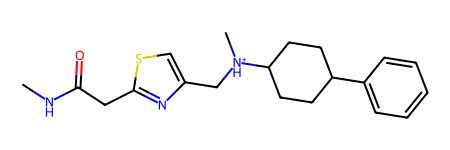

In [46]:
Chem.MolFromSmiles(zinc_data['smiles'][327])

In [39]:
def build_unique_vocabulary(vocabulary, zinc_data, valency_dict):
  '''
  Goal of this function is to assign unique "words" to every molecular structure previously identified
  -------------------------------------------------------------------------
  -------------------------------------------------------------------------
  
  Parameters:
    vocabulary:
    zinc_data:
    valency_dict:

  Returns:
    token_dictionary: index representations of the original chemical structure
    unique_vocab: the dictionary containing the identified unique chemical vocabulary

  '''

  token_dictionary         = {}
  unique_vocab             = {}
  vocab_counter            = 0

  for index in tqdm(vocabulary, total = len(vocabulary)):
    smiles_rep             = Chem.MolFromSmiles(zinc_data['smiles'][index])
    token_representations  = []
    valencies              = valency_dict[index]
#     print(valencies)
#     valencies              = ''.join([str(val) for val in valencies])
    print(index)
    for cat_index, category in enumerate(vocabulary[index]):
      aromatic_counter     = 0
      atoms                = ''
      valency              = ''
      category_items       = vocabulary[index][category][0]
      bond_index_list      = []
      
#       print(len(valencies), category)
      valency              = valencies[cat_index]
      
      if isinstance(category_items, list):
        for item in category_items:
            aromatic_counter += 1

            # Atomatic atoms order is accurate for bond connections (first and last element are bonded as well)
            # Confirmed this by running a sorting algorithm that returned the original string before sorting
            atoms            += item[1]
            # Retrieves Connections of all atoms (Needed for Aromatics)
            bond_indexes      = [(category_items[i][0], category_items[i][1]) for i, bond in enumerate(category_items)
                                if smiles_rep.GetBondBetweenAtoms(bond[0], item[0]) is not None]
            
        if 'Aromatic_Atoms' in category:
          # Regardless of order, we want CCNNCC == CCCCNN
          # Since we are only considered with the ring backbone, these structures are equivalent
          atoms              = canonicalize_string(atoms, valency) + '=' # add equal to indicate aromatic
        
        if 'ring' in category:
          atoms              = canonicalize_string(atoms, valency)
            
        # Unique way to identify double bonds
        if 'Double_Bonds' in category:
          
          isomerism = ' ' + molecule_df[index]['Bond_Isomerism'][0]
          atoms     = canonicalize_string(atoms, valency)
          atoms    += isomerism
          atoms    += '=='

        # Unique_way to identify triple bonds
        elif 'Triple_Bonds' in category:
    
          atoms     = canonicalize_string(atoms, valency)
          atoms    += '==='
            
      else:
        atoms       += category_items[1]
        atoms       = canonicalize_string(atoms, valency)
        atoms      += ' TQ'
 
      if atoms not in unique_vocab:
          unique_vocab[atoms] = vocab_counter
          vocabulary_token    = unique_vocab[atoms]
          vocab_counter      += 1
      else:
          vocabulary_token    = unique_vocab[atoms]

      token_representations.append(vocabulary_token)

    # counter +=1
    
    token_dictionary[index] = token_representations
  return token_dictionary, unique_vocab


token_dictionary, unique_vocab = build_unique_vocabulary(vocabulary, zinc_data, valency_dict)


  7%|▋         | 66/1001 [00:00<00:00, 1647.88it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
N [2, 1] 


ValueError: The length of ring_string and properties must match.

In [18]:
flipped_vocab = {value: key for key, value in unique_vocab.items()}

Vocabulary Token:   ==OCenon


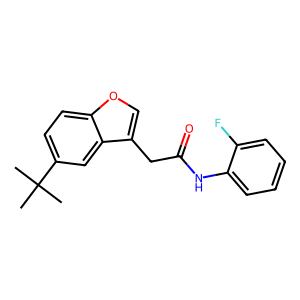

In [19]:
from rdkit.Chem import Draw

def validate_preprocess(unique_vocab, vocab_index = 259, choose_index = None):

  '''
  This function draws the molecular structure of any molecule containing
  the desired unique_vocab instance for visual validation of joining rings
  for the preprocessing of nodes in the junction tree algorithm earlier

  Paramters:
    unique_vocab:
    vocab_index:

  '''
  flipped_vocab = {value: key for key, value in unique_vocab.items()}

  if not choose_index:
    found_indexes = []
    for index in token_dictionary:
      try:
        index_found = token_dictionary[index].index(vocab_index)
        found_indexes.append(index)
      except ValueError:
        pass
  else:
    found_indexes = [choose_index]

  # Convert the SMILES string to an RDKit molecule object
  molecules = [Chem.MolFromSmiles(zinc_data['smiles'][index]) for index in found_indexes]

  # [print(list(atom)) for atom in Chem.GetSymmSSSR(molecule)]
  # Draw the molecules
  print('Vocabulary Token: ', flipped_vocab[vocab_index])


  return Draw.MolToImage(molecules[0])


validate_preprocess(unique_vocab, vocab_index = 2, choose_index = 0)

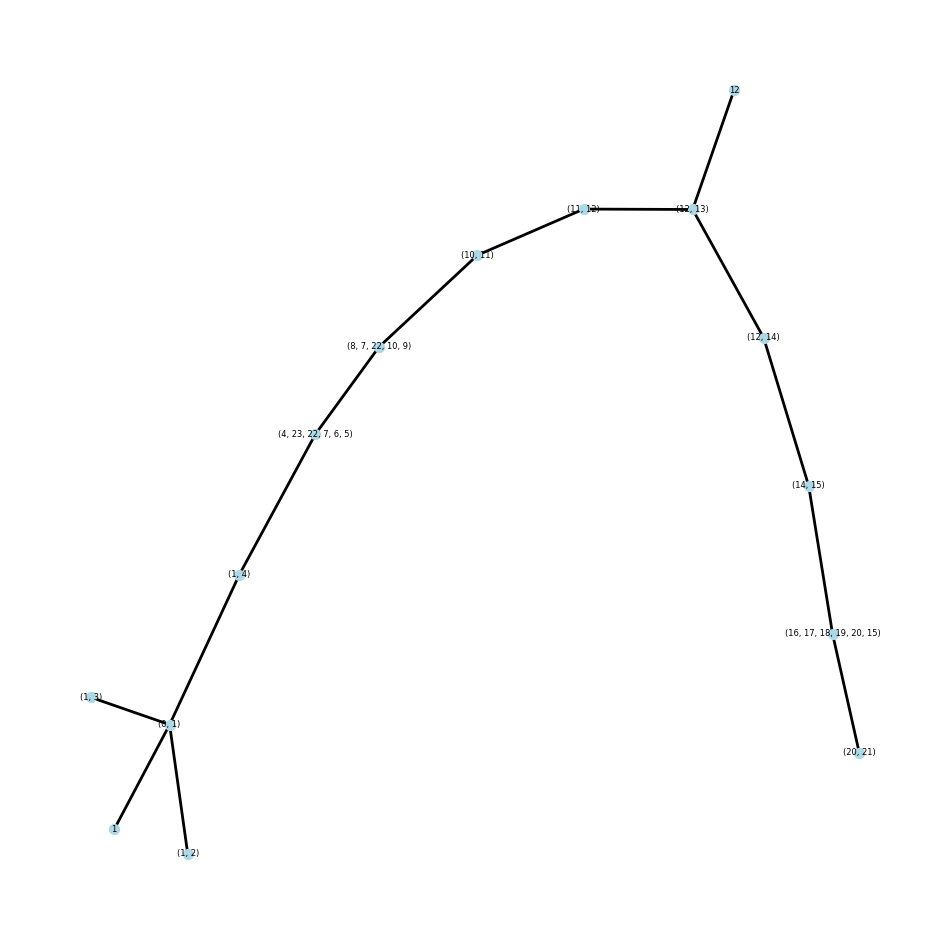

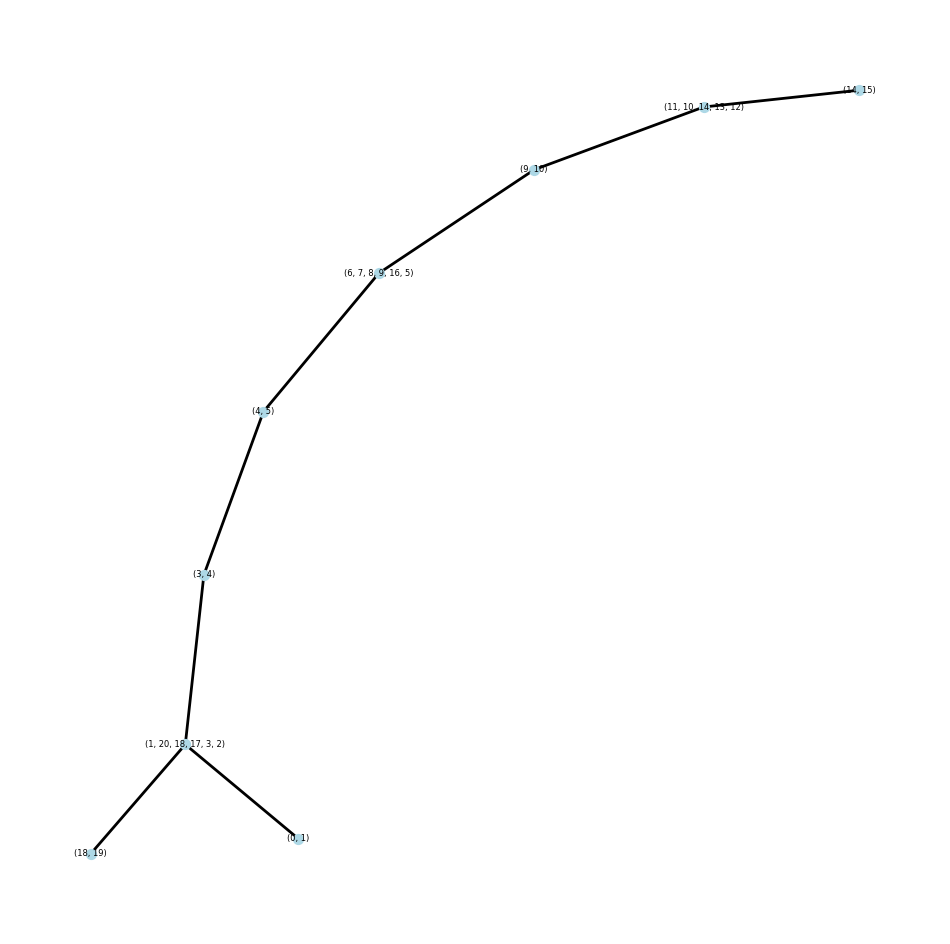

In [20]:
def plot_junction_tree(junction_tree, random_var = False, n_trees = 10, start_index = 0):
  # Draw the graph
  def plot(tree):
      plt.figure(figsize=(12, 12))  # Set the size of the plot
      pos = nx.spring_layout(tree)  # Positions for all nodes

      # Nodes
      nx.draw_networkx_nodes(tree, pos, node_size=50, node_color="lightblue")

      # Edges
      nx.draw_networkx_edges(tree, pos, width=2)

      # Labels
      nx.draw_networkx_labels(tree, pos, font_size=6, font_family="sans-serif")

      # Show the plot
      plt.axis("off")  # Turn off the axis
      plt.show()

  if not random_var:
     for tree in junction_tree[start_index:start_index + n_trees]:
      plot(tree)

  elif isinstance(junction_tree, list) and random_var:
    trees   = [random.randint(0, len(junction_tree)) for _ in range(n_trees)]
    for tree in junction_tree[:n_trees]:
      plot(tree)

plot_junction_tree(junction_tree, random_var = False, start_index = 0, n_trees = 2)


In [21]:
def substitute_vocabulary(adjacency_matricies, token_dictionary):
  ''' 
  Junction tree and adjacency matricies can be used with the token dictionary
  to map back the vocabulary into the adjacency_matricies
  
  Parameters:
      adjacency_matricies:
      token_dictionary:
      
  Returns:
      
      
  '''
  for index, atoms in tqdm(token_dictionary.items(), total = len(list(token_dictionary.values()))):
      list_index = 0
    
      matrix     = adjacency_matricies[index]
      for i in range(len(matrix)):
        for j in range(len(matrix)):
#             print(adjacency_matricies[index][i][j])
            if matrix[i][j] != 0:
#                 print(atoms, list_index, matrix.shape)
                atom_conversion                  = atoms[j]
                adjacency_matricies[index][i][j] = atom_conversion
                list_index += 1
        

  return np.array(adjacency_matricies)


adjacency_substituted = substitute_vocabulary(padded_matricies, token_dictionary)


100%|██████████| 1001/1001 [00:00<00:00, 5196.05it/s]


**Next Step. Look into vocabulary aspect of this code 27Feb2024**
1. Ideally we would match the papers token number
2. The subsituting is working properly